Subsetting utilities
================

`clisops` comes with some utilities to perform common tasks that are either not implemented in xarray, or that are implemented but do not have the generality needed for climate science work. Here we show examples of the `clisops.core.subset` submodule.

In [ ]:
import xarray as xr
xr.set_options(display_style='html')
from clisops.core import subset
%matplotlib inline

In [ ]:
ds = xr.tutorial.open_dataset('air_temperature')
ds.coords

Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

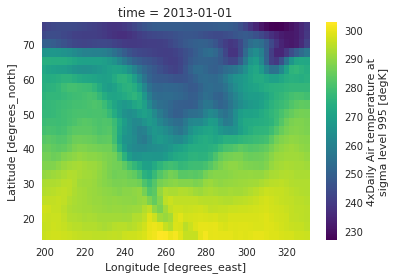

In [ ]:
ds.air.isel(time=0).plot()  # Simple index-selection with xarray

## subset_bbox : using a latitude-longitude bounding box

In the previous example notebook, we used xarray's `.sel()` to cut a lat-lon subset of our data. clisops offers the same utility, but with more generality. For example, if we mindlessly try xarray's method on our dataset:

In [ ]:
ds.sel(lat=slice(45, 50), lon=slice(-60, -55)).coords

Coordinates:
  * lat      (lat) float32 
  * lon      (lon) float32 
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

As you can see, `lat` and `lon` are empty. In this dataset, the lats are defined in descending order and lons are in the range \[0, 360[ instead of [-180, 180[, which is why xarray's method did not return the expected result. clisops understands these nuances:

In [ ]:
subset.subset_bbox(ds, lat_bnds=[45, 50], lon_bnds=[-60, -55]).coords

Coordinates:
  * lat      (lat) float32 50.0 47.5 45.0
  * lon      (lon) float32 300.0 302.5 305.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

### When lat and lon are 2-D
`subset_bbox` also manages cases where the lat-lon coordinates are not sorted 1D vectors, for example with this more complex dataset:

<div class="alert alert-warning">

Most `subset` methods expect the input dataset / dataarray to have `lat` and `lon` as variables. It may be able to understand your data if other common names are used (like `latitude`, or `lons`), but we recommend renaming the variables before using the tool (like in this example).

</div>

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'latitude of RHO-points')

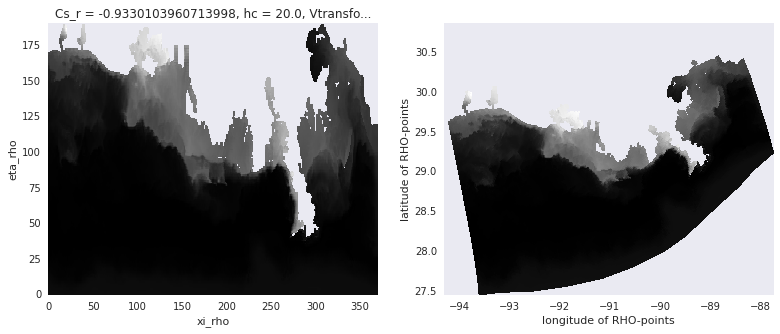

In [ ]:
ds_roms = xr.tutorial.open_dataset('ROMS_example').rename(lon_rho='lon', lat_rho='lat')
salt = ds_roms.salt.isel(ocean_time=0, s_rho=0)

# import plotting stuff
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (13, 5)

fig, (axEtaXi, axLatLon) = plt.subplots(1, 2)
salt.plot(cmap=plt.cm.gray_r, ax=axEtaXi, add_colorbar=False)
axLatLon.pcolormesh(salt.lon, salt.lat, salt)
axLatLon.set_xlabel(salt.lon.long_name)
axLatLon.set_ylabel(salt.lat.long_name)

/srv/conda/envs/notebook/lib/python3.7/site-packages/clisops/core/subset.py:272: UserWarning: lat and lon-like dimensions are not found among arg `<xarray.DataArray 'salt' (eta_rho: 191, xi_rho: 371)>
array([[34.953022, 34.955223, 34.957733, ..., 34.91684 , 34.913895, 34.913876],
       [34.95414 , 34.957577, 34.961086, ..., 34.916145, 34.91495 , 34.913864],
       [34.959286, 34.963936, 34.968594, ..., 34.923023, 34.92564 , 34.926853],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]],
      dtype=float32)
Coordinates:
    Cs_r        float64 ...
    lon         (eta_rho, xi_rho) float64 -93.6 -93.58 -93.57 ... -88.88 -88.87
    hc          float64 ...
    h           (eta_rho, xi_rho) float64 ...
    lat         (eta_rho, xi_rho) float64 27.45 27.45 27.45 ... 30.85 30.86
    Vtransform

Text(0, 0.5, 'latitude of RHO-points')

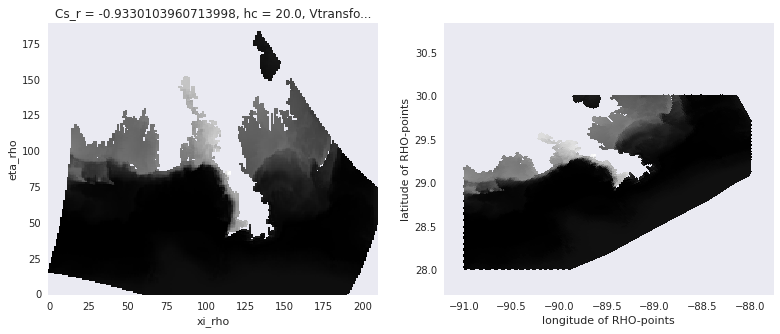

In [ ]:
salt_bb = subset.subset_bbox(salt, lat_bnds=[28, 30], lon_bnds=[-91, -88])

fig, (axEtaXi, axLatLon) = plt.subplots(1, 2)
salt_bb.plot(cmap=plt.cm.gray_r, ax=axEtaXi, add_colorbar=False)
axLatLon.pcolormesh(salt_bb.lon, salt_bb.lat, salt_bb)
axLatLon.set_xlabel(salt_bb.lon.long_name)
axLatLon.set_ylabel(salt_bb.lat.long_name)

### Add time subsetting
`subset_bbox` and other methods of the submodule give options to also give time bounds. These options are mostly for convenience as only some basics sanity checks are performed.

In [ ]:
subset.subset_bbox(ds, lat_bnds=[45, 50], lon_bnds=[-60, -55],
                       start_date='2013-02', end_date='2013-08').coords

Coordinates:
  * lat      (lat) float32 50.0 47.5 45.0
  * lon      (lon) float32 300.0 302.5 305.0
  * time     (time) datetime64[ns] 2013-02-01 ... 2013-08-31T18:00:00

## subset_gridpoint :  Selecting grid points
`subset_gridpoint` can be used for selecting single locations. Compared to `.sel()`, this method adds a `tolerance` parameter in *meters* so that it finds the nearest point from the given coordinate within this distance, or else it returns `NaN`.

In [ ]:
lon_pt = -70.2
lat_pt = 50.1

# Get timeseries for point within 100 km of (-70.2, 50.1)
ds3 = subset.subset_gridpoint(ds, lon=lon_pt, lat=lat_pt, tolerance=100 * 1000)
ds3.coords

Coordinates:
    lat      float32 50.0
    lon      float32 290.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

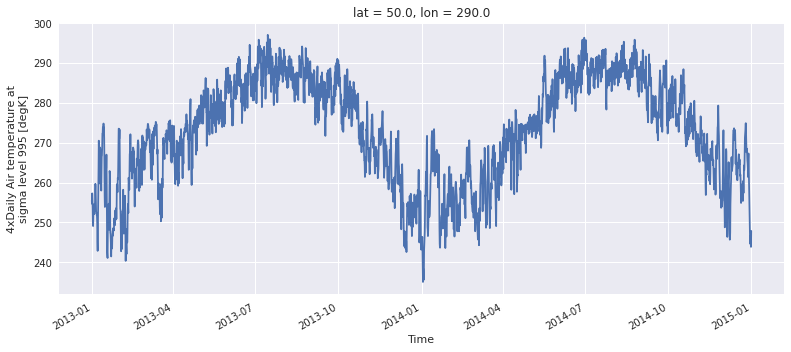

In [ ]:
ds3.air.plot()

This also works with a list of coordinates. In that case, a new dimension `site` concatenates the selected gridpoints. Moreover, passing `add_distance = True` allows us to inspect how close the selected gridpoints were from the requested coordinates. In this example, the third point (-90, 54.1) is a little bit further than 100 km from the nearest gridpoint, so the coordinate of this gridpoint and the distance are returned, but the values are masked with NaN (and thus they do not appear on the graph).

Coordinates:
    lat       (site) float32 45.0 50.0 55.0
    lon       (site) float32 295.0 290.0 270.0
  * time      (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
    distance  (site) float64 0.0 1.814e+04 1.002e+05


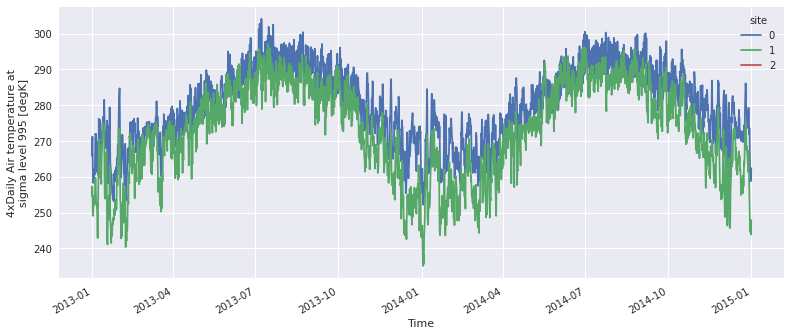

In [ ]:
lon_pt = [-65, -70.2, -90]
lat_pt = [45, 50.1, 54.1]

# Get timeseries for point within 100 km of each points
ds3 = subset.subset_gridpoint(ds, lon=lon_pt, lat=lat_pt, tolerance=100 * 1000, add_distance=True)
print(ds3.coords)
ds3.air.plot(hue='site')

## subset_shape : Selecting a region from a polygon
If the region we want to keep in our dataset is complex, we can use `subset_shape` and pass a polygon. The input shape can be any georeferenced data file understood by [geopandas](http://geopandas.org/) and [fiona](https://fiona.readthedocs.io/en/latest/) that run under the hood. For example here with a geojson file of Canada available online:

2020-11-05 12:04:32,079 - root - INFO - No file or no dimensions found in arg `https://raw.githubusercontent.com/johan/world.geo.json/master/countries/CAN.geo.json`.


/srv/conda/envs/notebook/lib/python3.7/site-packages/clisops/core/subset.py:278: UserWarning: CRS definitions are similar but raster lon values must be wrapped.
  final = func(*formatted_args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/clisops/core/subset.py:461: UserWarning: Wrapping longitudes at 180 degrees.
  warnings.warn("Wrapping longitudes at 180 degrees.")


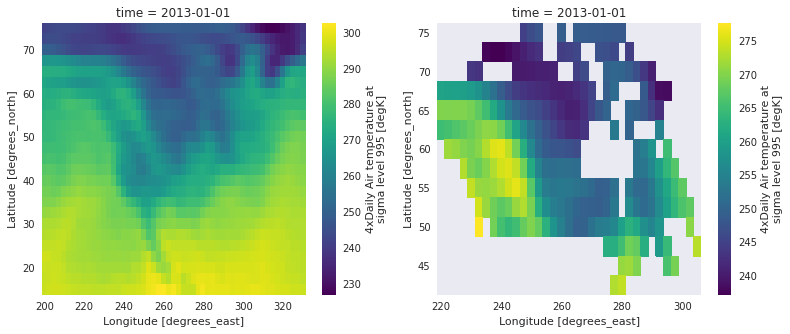

In [ ]:
ds_can = subset.subset_shape(ds, 'https://raw.githubusercontent.com/johan/world.geo.json/master/countries/CAN.geo.json')

fig, (axall, axcan) = plt.subplots(1, 2)
ds.air.isel(time=0).plot(ax=axall)
ds_can.air.isel(time=0).plot(ax=axcan)

We can also create a mask to divide the data in regions. In the example, we load the shapes for Canada, Mexico and the US, merge them with pandas and then create the mask. `create_mask` is a bit more restrictive than the other methods showed here and specifically asks for the `x` and `y` dims. Also, we need to pass `wrap_lons=True` since our longitudes go from 0 to 360 instead of -180 to 180.

In [ ]:
import pandas as pd
import geopandas as gpd
can = gpd.read_file('https://raw.githubusercontent.com/johan/world.geo.json/master/countries/CAN.geo.json')
usa = gpd.read_file('https://raw.githubusercontent.com/johan/world.geo.json/master/countries/USA.geo.json')
mex = gpd.read_file('https://raw.githubusercontent.com/johan/world.geo.json/master/countries/MEX.geo.json')
northam = pd.concat([can, usa, mex]).reset_index()

In [ ]:
mask = subset.create_mask(x_dim=ds.lon, y_dim=ds.lat, poly=northam, wrap_lons=True)

/srv/conda/envs/notebook/lib/python3.7/site-packages/clisops/core/subset.py:546: UserWarning: Wrapping longitudes at 180 degrees.
  warnings.warn("Wrapping longitudes at 180 degrees.")
/srv/conda/envs/notebook/lib/python3.7/site-packages/clisops/core/subset.py:578: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +proj=longlat +datum=WGS84 +no_defs +type=crs +lon ...
Right CRS: +proj=longlat +ellps=WGS84 +lon_wrap=180 +datum=WG ...

  point_in_poly = gpd.tools.sjoin(gdf_points, poly, how="left", op="intersects")


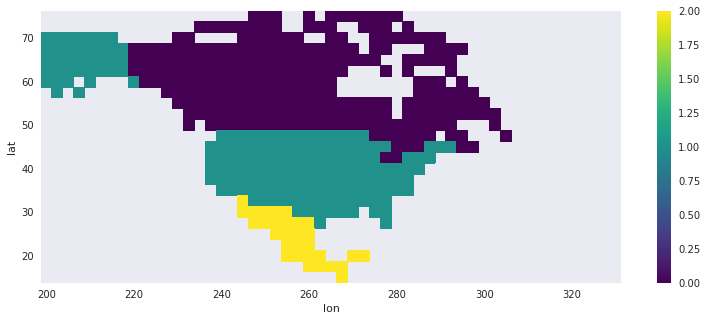

In [ ]:
mask.T.plot() # The transpose is needed because create_mask returns lon, lat instead the input lat, lon.

The same can be done with 2D lat/lon coordinates. Here get the regions of `salt` that are within the boundaries of the US as defined in our geojson data. As our data comes from a small region in the Gulf of Mexico and our USA mask is quite coarse, the following isn't really helpful. In any case, it illustrates what can be done with clisops.

In [ ]:
usa_mask = subset.create_mask(x_dim=salt.lon, y_dim=salt.lat, poly=usa)

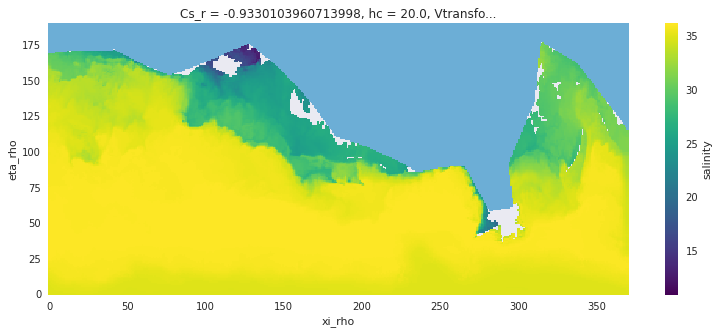

In [ ]:
salt.plot()
usa_mask.plot(cmap=plt.cm.Blues_r, add_colorbar=False)